In [1]:
using SpecialFunctions, LinearAlgebra, BlockBandedMatrices, Plots

In [2]:
digits = 200
p = Int64(round(-log(10.0^(-digits))/log(2)+1))
setprecision(p)
eps(BigFloat)

1.306420176630260372014458839381409187692885829284212960763337974781164378711899959012357647219720206961567756086182151119073634759644348205532976426279074776518688729228857922353671951349060138355967699e-200

Here is a function that generates the Jacobi matrices $X_n$ and $Y_n$ for OPs on the curve $x^4 + y^4 = 1$, e.g.,
$$
X_n = \left(
\begin{array}{c c c c c c}
0 & B_0^x & & & & \\
\left(B_0^x\right)^{\intercal} & 0 & B_1^{x} & & & \\
 & \left(B_1^x\right)^{\intercal} & \ddots & \ddots & &  \\
 & & \ddots & & B_{n-1}^x & \\
 & & & \left(B_{n-1}^x\right)^{\intercal} & 0 & B_n^x \\
 & & & & \left(B_n^x\right)^{\intercal} & 0
\end{array}
\right).
$$
Some experimentation suggests that if $d$ digits are used, then the entries of $B_n^x$ and $B_n^y$ are accurate to roughly $d-3n/2$ digits. Hence, after roughly $2/3d$ iterations, all accurate digits are destroyed.

In [3]:
function quarticjacobi(::Type{T},nmax) where T
N = 1+2+3+4*(nmax-1)+max(0,1-nmax)
if nmax == 0
    X = BlockBandedMatrix(BigFloat(0)*Zeros(N,N), (1:nmax+2,1:nmax+2), (1,1))
    Y = BlockBandedMatrix(BigFloat(0)*Zeros(N,N), (1:nmax+2,1:nmax+2), (1,1))
else
    X = BlockBandedMatrix(BigFloat(0)*Zeros(N,N), ([1:3;fill(4,nmax-1)],[1:3;fill(4,nmax-1)]), (1,1))
    Y = BlockBandedMatrix(BigFloat(0)*Zeros(N,N), ([1:3;fill(4,nmax-1)],[1:3;fill(4,nmax-1)]), (1,1))
end
Q0=1/normp([0,0,1],"ee")
b0x = [normp([0,0,Q0],"oe") 0]
b0y = [0 normp([0,0,Q0],"eo")]
#view(X,Block(1,2))[:] = b0x; view(X,Block(2,1))[:] = b0x'
view(X,Block(1,2))[:,:] = b0x; view(X,Block(2,1))[:,:] = b0x'
view(Y,Block(1,2))[:] = b0y; view(Y,Block(2,1))[:] = b0y'
#Symmetric fills in empty entries in the matrix
if nmax > 0
p1=Q0/b0x[1,1]
q1=Q0/b0y[1,2]
b1x = BigFloat(0)*zeros(2,3); b1y = BigFloat(0)*zeros(2,3)
b1x[1,1] = normp([p1,0,-b0x[1,1]*Q0],"ee")
b1x[2,2] = normp([0,0,q1],"oo")
p2=[p1,0,-b0x[1,1]*Q0]/b1x[1,1]
q2=[q1]/b1x[2,2]
b1y[1,2] = ip([0,0,q2[1]],[0,0,p1],"oo")
app2=p1/q2[1]
abs(app2-b1y[1,2])
u4c=[0,q1,-b0y[1,2]*Q0]
b1y[2,1]=ip(u4c,p2,"ee")
b1y[2,3]=sqrt( ip(u4c,u4c,"ee") - b1y[2,1]^2 )
r2=[-b1y[2,1]*p2[1],q1,-b0y[1,2]*Q0-b1y[2,1]*p2[end]]/b1y[2,3]
view(X,Block(2,3))[:] = b1x; view(X,Block(3,2))[:] = b1x'
view(Y,Block(2,3))[:] = b1y; view(Y,Block(3,2))[:] = b1y'
end
if nmax > 1
u1=BigFloat(0)*zeros(3,1);u1.=p2; u1[end]-=b1x[1,1]*p1
u2=vcat(q2,0,-b1x[2,2]*q1)
u3=BigFloat(0)*zeros(3,1);u3.=r2
u4=BigFloat(0)*zeros(3,1);u4.=p2;u4[end]-=b1y[2,1]*q1
u5=vcat(0,q2,-b1y[1,2]*p1)
u6=BigFloat(0)*zeros(3,1);u6.=r2;u6[end]-=b1y[2,3]*q1
b2x = BigFloat(0)*zeros(3,4); b2y = BigFloat(0)*zeros(3,4)
b2x[1,1]=normp(u1,"oe"); p3=u1/b2x[1,1]
b2x[2,2]=normp(u2,"eo"); q3=u2/b2x[2,2]
b2x[3,1]=ip(u3,p3,"oe")
v3=u3-b2x[3,1]*p3
b2x[3,3]=sqrt(ip(u3,u3,"oe")-b2x[3,1]^2)
r3=v3/b2x[3,3]
b2y[3,2]=ip(u6,q3,"eo")
v4=u6-b2y[3,2]*q3
b2y[3,4]=sqrt(ip(u6,u6,"eo")-b2y[3,2]^2)
s3=v4/b2y[3,4]
b2y[1,2]=ip(u4,q3,"eo")
b2y[1,4]=ip(u4,s3,"eo")
b2y[2,1]=ip(u5,p3,"oe")
b2y[2,3]=ip(u5,r3,"oe")
view(X,Block(3,4))[:] = b2x; view(X,Block(4,3))[:] = b2x'
view(Y,Block(3,4))[:] = b2y; view(Y,Block(4,3))[:] = b2y'
end
if nmax > 2
u1=BigFloat(0)*zeros(5,1);u1[1:3]=p3;u1[3:5]-=b2x[1,1]*p2;u1[3:5]-=b2x[3,1]*r2
u2=BigFloat(0)*zeros(3,1);u2.=q3;u2[3]-=b2x[2,2]*q2[1];
u3=BigFloat(0)*zeros(5,1);u3[1:3]=r3;u3[3:5]-=b2x[3,3]*r2;
u4=BigFloat(0)*zeros(3,1);u4.=s3;
u5=BigFloat(0)*zeros(3,1);u5.=p3;u5[3]-=b2y[2,1]*q2[1];
u6=BigFloat(0)*zeros(5,1);u6[2:4]=q3;u6[3:5]-=b2y[1,2]*p2;u6[3:5]-=b2y[3,2]*r2
u7=BigFloat(0)*zeros(3,1);u7.=r3;u7[3]-=b2y[2,3]*q2[1];
u8=BigFloat(0)*zeros(5,1);u8[3:5]-=b2y[1,4]*p2;u8[3:5]-=b2y[3,4]*r2;u8[2]=s3[1];u8[4]+=s3[3];u8[5]+=s3[2];u8[1]=-s3[2]
b3x = BigFloat(0)*zeros(4,4); b3y = BigFloat(0)*zeros(4,4)
b3x[1,1]=normp(u1,"ee"); p4=u1/b3x[1,1]
b3x[2,2]=normp(u2,"oo"); q4=u2/b3x[2,2]
b3x[3,1]=ip(u3,p4,"ee");b3x[3,3]=sqrt(ip(u3,u3,"ee") - b3x[3,1]^2);
v3=u3-b3x[3,1]*p4; r4=v3/b3x[3,3]
b3x[4,2]=ip(u4,q4,"oo");b3x[4,4]=sqrt(ip(u4,u4,"oo") - b3x[4,2]^2);
v4=u4-b3x[4,2]*q4; s4=v4/b3x[4,4]
b3y[1,2] = ip(u5,q4,"oo")
b3y[1,4] = ip(u5,s4,"oo")
b3y[2,1] = ip(u6,p4,"ee")
b3y[2,3] = ip(u6,r4,"ee")
b3y[3,2] = ip(u7,q4,"oo")
b3y[3,4] = ip(u7,s4,"oo")
b3y[4,1] = ip(u8,p4,"ee")
b3y[4,3] = ip(u8,r4,"ee")
view(X,Block(4,5))[:] = b3x; view(X,Block(5,4))[:] = b3x'
view(Y,Block(4,5))[:] = b3y; view(Y,Block(5,4))[:] = b3y'
end
if nmax > 3
    bx = BigFloat(0)*zeros(4,4,nmax+1); by = BigFloat(0)*zeros(4,4,nmax+1)
    bx[:,:,1] = b3x; by[:,:,1] = b3y;
    Qn=BigFloat(0)*zeros(4,nmax+5)
    Qn1=BigFloat(0)*zeros(4,nmax+5)
    Qo=BigFloat(0)*zeros(4,nmax+5)
    U=BigFloat(0)*zeros(8,nmax+5)
    Qn[1,1:5]=p4;Qn[2,1:3]=q4;Qn[3,1:5]=r4;Qn[4,1:3]=s4;
    Qo[1,1:3]=p3;Qo[2,1:3]=q3;Qo[3,1:3]=r3;Qo[4,1:3]=s3;
    errest=zeros(nmax,1)
    for k = 1:nmax-3
        l = k+4
        if mod(k,2)==1
            ind1=l;ind2=l-2;
            U[1,1:ind1]=Qn[1,1:ind1];U[1,3:ind1]-=bx[1,1,k]*Qo[1,1:ind2];U[1,3:ind1]-=bx[3,1,k]*Qo[3,1:ind2]
            U[2,1:ind2]=Qn[2,1:ind2];U[2,3:ind1]-=bx[2,2,k]*Qo[2,1:ind2];U[2,3:ind1]-=bx[4,2,k]*Qo[4,1:ind2]
            U[3,1:ind1]=Qn[3,1:ind1];U[3,3:ind1]-=bx[3,3,k]*Qo[3,1:ind2]
            U[4,1:ind2]=Qn[4,1:ind2];U[4,3:ind1]-=bx[4,4,k]*Qo[4,1:ind2]
            U[5,1:ind1]=Qn[1,1:ind1];U[5,3:ind1]-=by[2,1,k]*Qo[2,1:ind2];U[5,3:ind1]-=by[4,1,k]*Qo[4,1:ind2]
            U[7,1:ind1]=Qn[3,1:ind1];U[7,3:ind1]-=by[2,3,k]*Qo[2,1:ind2];U[7,3:ind1]-=by[4,3,k]*Qo[4,1:ind2]
            U[6,2:2:ind1-1]=Qn[2,1:2:ind2];U[6,1:2:ind1-4]=-Qn[2,2:2:ind2-1];U[6,5:2:ind1]+=Qn[2,2:2:ind2-1];
            U[6,3:ind1]-=by[1,2,k]*Qo[1,1:ind2];U[6,3:ind1]-=by[3,2,k]*Qo[3,1:ind2];
            U[8,2:2:ind1-1]=Qn[4,1:2:ind2];U[8,1:2:ind1-4]=-Qn[4,2:2:ind2-1];U[8,5:2:ind1]+=Qn[4,2:2:ind2-1];
            U[8,3:ind1]-=by[1,4,k]*Qo[1,1:ind2];U[8,3:ind1]-=by[3,4,k]*Qo[3,1:ind2];
            type1="oe";type2="eo"
            bx[1,1,k+1]=normp(U[1,1:ind1],type1); Qn1[1,1:ind1]=U[1,1:ind1]/bx[1,1,k+1]
            bx[2,2,k+1]=normp(U[2,1:ind1],type2); Qn1[2,1:ind1]=U[2,1:ind1]/bx[2,2,k+1]
            bx[3,1,k+1]=ip(U[3,1:ind1],Qn1[1,1:ind1],type1);bx[3,3,k+1]=sqrt(ip(U[3,1:ind1],U[3,1:ind1],type1) - bx[3,1,k+1]^2);
            Qn1[3,1:ind1]=(U[3,1:ind1]-bx[3,1,k+1]*Qn1[1,1:ind1])/bx[3,3,k+1]
            bx[4,2,k+1]=ip(U[4,1:ind1],Qn1[2,1:ind1],type2);bx[4,4,k+1]=sqrt(ip(U[4,1:ind1],U[4,1:ind1],type2) - bx[4,2,k+1]^2);
            Qn1[4,1:ind1]=(U[4,1:ind1]-bx[4,2,k+1]*Qn1[2,1:ind1])/bx[4,4,k+1]
            by[1,2,k+1] = ip(U[5,1:ind1],Qn1[2,1:ind1],type2)
            by[1,4,k+1] = ip(U[5,1:ind1],Qn1[4,1:ind1],type2)
            by[2,1,k+1] = ip(U[6,1:ind1],Qn1[1,1:ind1],type1)
            by[2,3,k+1] = ip(U[6,1:ind1],Qn1[3,1:ind1],type1)
            by[3,2,k+1] = ip(U[7,1:ind1],Qn1[2,1:ind1],type2)
            by[3,4,k+1] = ip(U[7,1:ind1],Qn1[4,1:ind1],type2)
            by[4,1,k+1] = ip(U[8,1:ind1],Qn1[1,1:ind1],type1)
            by[4,3,k+1] = ip(U[8,1:ind1],Qn1[3,1:ind1],type1)
            view(X,Block(k+4,k+5))[:] = bx[:,:,k+1]; view(X,Block(k+5,k+4))[:] = bx[:,:,k+1]'
            view(Y,Block(k+4,k+5))[:] = by[:,:,k+1]; view(Y,Block(k+5,k+4))[:] = by[:,:,k+1]'
            Qo[1,1:ind1]= Qn[1,1:ind1];Qo[2,1:ind2]= Qn[2,1:ind2];Qo[3,1:ind1]= Qn[3,1:ind1];Qo[4,1:ind2]= Qn[4,1:ind2]
            Qn[1,1:ind1]= Qn1[1,1:ind1];Qn[2,1:ind1]= Qn1[2,1:ind1];Qn[3,1:ind1]= Qn1[3,1:ind1];Qn[4,1:ind1]= Qn1[4,1:ind1]
            errest[k] =  abs(sqrt(ip(Qn1[3,1:ind1],Qn1[3,1:ind1],type1))-1)
        else
            ind1=l+1;ind2=l-1;ind3=l-3
            U[1,1:ind2]=Qn[1,1:ind2];U[1,3:ind1]-=bx[1,1,k]*Qo[1,1:ind2];U[1,3:ind1]-=bx[3,1,k]*Qo[3,1:ind2]
            U[2,1:ind2]=Qn[2,1:ind2];U[2,3:ind2]-=bx[2,2,k]*Qo[2,1:ind3];U[2,3:ind2]-=bx[4,2,k]*Qo[4,1:ind3]
            U[3,1:ind2]=Qn[3,1:ind2];U[3,3:ind1]-=bx[3,3,k]*Qo[3,1:ind2]
            U[4,1:ind2]=Qn[4,1:ind2];U[4,3:ind2]-=bx[4,4,k]*Qo[4,1:ind3]
            U[5,1:ind2]=Qn[1,1:ind2];U[5,3:ind2]-=by[2,1,k]*Qo[2,1:ind3];U[5,3:ind2]-=by[4,1,k]*Qo[4,1:ind3]
            U[7,1:ind2]=Qn[3,1:ind2];U[7,3:ind2]-=by[2,3,k]*Qo[2,1:ind3];U[7,3:ind2]-=by[4,3,k]*Qo[4,1:ind3]
            U[6,2:2:ind1-1]=Qn[2,1:2:ind2];U[6,1:2:ind1-4]=-Qn[2,2:2:ind2-1];U[6,5:2:ind1]+=Qn[2,2:2:ind2-1];
            U[6,3:ind1]-=by[1,2,k]*Qo[1,1:ind2];U[6,3:ind1]-=by[3,2,k]*Qo[3,1:ind2];
            U[8,2:2:ind1-1]=Qn[4,1:2:ind2];U[8,1:2:ind1-4]=-Qn[4,2:2:ind2-1];U[8,5:2:ind1]+=Qn[4,2:2:ind2-1];
            U[8,3:ind1]-=by[1,4,k]*Qo[1,1:ind2];U[8,3:ind1]-=by[3,4,k]*Qo[3,1:ind2];
            type1="ee";type2="oo"
            bx[1,1,k+1]=normp(U[1,1:ind1],type1); Qn1[1,1:ind1]=U[1,1:ind1]/bx[1,1,k+1]
            bx[2,2,k+1]=normp(U[2,1:ind2],type2); Qn1[2,1:ind2]=U[2,1:ind2]/bx[2,2,k+1]
            bx[3,1,k+1]=ip(U[3,1:ind1],Qn1[1,1:ind1],type1);bx[3,3,k+1]=sqrt(ip(U[3,1:ind1],U[3,1:ind1],type1) - bx[3,1,k+1]^2);
            Qn1[3,1:ind1]=(U[3,1:ind1]-bx[3,1,k+1]*Qn1[1,1:ind1])/bx[3,3,k+1]
            bx[4,2,k+1]=ip(U[4,1:ind2],Qn1[2,1:ind2],type2);bx[4,4,k+1]=sqrt(ip(U[4,1:ind2],U[4,1:ind2],type2) - bx[4,2,k+1]^2);
            Qn1[4,1:ind2]=(U[4,1:ind2]-bx[4,2,k+1]*Qn1[2,1:ind2])/bx[4,4,k+1]
            by[1,2,k+1] = ip(U[5,1:ind2],Qn1[2,1:ind2],type2)
            by[1,4,k+1] = ip(U[5,1:ind2],Qn1[4,1:ind2],type2)
            by[2,1,k+1] = ip(U[6,1:ind1],Qn1[1,1:ind1],type1)
            by[2,3,k+1] = ip(U[6,1:ind1],Qn1[3,1:ind1],type1)
            by[3,2,k+1] = ip(U[7,1:ind2],Qn1[2,1:ind2],type2)
            by[3,4,k+1] = ip(U[7,1:ind2],Qn1[4,1:ind2],type2)
            by[4,1,k+1] = ip(U[8,1:ind1],Qn1[1,1:ind1],type1)
            by[4,3,k+1] = ip(U[8,1:ind1],Qn1[3,1:ind1],type1)
            view(X,Block(k+4,k+5))[:] = bx[:,:,k+1]; view(X,Block(k+5,k+4))[:] = bx[:,:,k+1]'
            view(Y,Block(k+4,k+5))[:] = by[:,:,k+1]; view(Y,Block(k+5,k+4))[:] = by[:,:,k+1]'
            Qo[1,1:ind2]= Qn[1,1:ind2];Qo[2,1:ind2]= Qn[2,1:ind2];Qo[3,1:ind2]= Qn[3,1:ind2];Qo[4,1:ind2]= Qn[4,1:ind2]
            Qn[1,1:ind1]= Qn1[1,1:ind1];Qn[2,1:ind2]= Qn1[2,1:ind2];Qn[3,1:ind1]= Qn1[3,1:ind1];Qn[4,1:ind2]= Qn1[4,1:ind2]
            errest[k] =  abs(sqrt(ip(Qn1[3,1:ind1],Qn1[3,1:ind1],type1))-1)
        end
        
    end 
end
    X,Y
end
c(i,j)=beta(BigFloat(j)/4+1,BigFloat(i)/4+1/4)
normp(a,ptype) = sqrt(ip(a,a,ptype))
function ip(a,b,ptype)
    k=Int64((length(a)-1)/2)
    a = a[end:-1:1]; b = b[end:-1:1]
    a = vcat(a[1],a); b = vcat(b[1],b)
    am = reshape(a,2,k+1)'; bm = reshape(b,2,k+1)'   
    am=am[:,end:-1:1]; bm=bm[:,end:-1:1]
    papb = 0
    for j = 0:2*k
        for i = 0:min(2,2*k-j)
            if i==0 
                linds = max(0,j-k):min(k,j)
                coeff = sum(am[end.-linds,1].*bm[end-j.+linds,1])
            elseif i == 1
                linds = max(0,j-k+1):min(k,j)
                s1 = sum(am[end.-linds,1].*bm[end-j.+linds,2])
                linds = max(0,j-k):min(k-1,j)
                coeff = s1 + sum(am[end.-linds,2].*bm[end-j.+linds,1])
            else
                linds = max(1,j-k+2):min(k,j+1)
                coeff = sum(am[1+end.-linds,2].*bm[end-1-j.+linds,2])
            end
            if ptype=="ee"
                papb = papb + coeff*c(4*k-2*j-2*i,2*i)
            elseif ptype=="oe"
                papb = papb + coeff*c(4*k+2-2*j-2*i,2*i)
            elseif ptype=="eo"
                papb = papb + coeff*c(4*k-2*j-2*i,2*i+2)
            else
                papb = papb + coeff*c(4*k+2-2*j-2*i,2*i+2)
            end
        end
    end
    papb
    end;

In [4]:
periods = 15
n=8*periods+7
@time X,Y = quarticjacobi(BigFloat,n);
commute=X*Y-Y*X
algeq=X^4+Y^4-I
commutest =norm(commute[1:end-4,:1:end-4])
algeqtest =  norm(algeq[1:end-12,:1:end-12])
@show commutest
@show algeqtest;

218.225537 seconds (254.95 M allocations: 15.216 GiB, 1.20% gc time)
commutest = 1.855742531814743108996435137020891085909939733900126810814353719621897388904690248135796570865872756846780430456101025070560556483996019131241683074469294273616733300677530489490871236627813187520415783e-17
algeqtest = 6.636611019785185393908886499930252198197870182913148206937759235702814928854759120765838130228572934937060868512500199966164859314575885802037989968164173482653227348355016626408251994451434980055196595e-20


The conjecture from the previous notebook is that the coefficient matrices are asymptotically 8-periodic, i.e., as $n \to \infty$,
\begin{eqnarray}
& B_{8n}^x \to \beta_0^x, \qquad & B_{8n}^{y} \to \beta_0^y \\
& B_{1+8n}^x \to \beta_1^x, \qquad & B_{1+8n}^{y} \to \beta_1^y \\
& \vdots & \\
& B_{7+8n}^x \to \beta_7^x, \qquad & B_{7+8n}^{y} \to \beta_7^y 
\end{eqnarray}
Hence, as $n\to \infty$
$$
X_n \to \left(
\begin{array}{c c c c c c c c c}
0 & B_0^x & & & & & & & &\\
\left(B_0^x\right)^{\intercal} & 0 & B_1^{x} & & & & & & & & \\
 & \left(B_1^x\right)^{\intercal} & \ddots & \ddots & & & & & & & \\
 & & \ddots &\ddots & \ddots & & & & & & \\
 & & & \left(\beta_{0}^x\right)^{\intercal} & 0 & \beta_1^x & & & & & \\
 & & & & \left(\beta_1^x\right)^{\intercal} & 0 & \beta_2^x & & & & \\
 & & & &                                    & \ddots & \ddots & \ddots & & &\\
 & & & &                                    &  & \left(\beta_6^x\right)^{\intercal} & 0 & \beta_7^x & &  \\
 & & & &                                    &  &         & \left(\beta_7^x\right)^{\intercal} & 0 & \beta_0^x &  \\
 & & & &                                    &  &         &      & \ddots  &     \ddots      & \ddots
\end{array}
\right).
$$

Suppose $n = 8p + 7$, then we estimate $\| B_{i+8j}^{x/y} - \beta_{i}^{x/y} \|, i = 0, \ldots, 7$ by
$$
e_j = \max_{i = 0, \ldots, 7} \lbrace \| B_{8j + i}^{x} - B_{8p + i}^{x} \|, \| B_{8j + i}^{y} - B_{8p + i}^{y} \|   \rbrace, \qquad j = 1, \ldots, p-1.
$$
Here is a plot of the $e_j$:

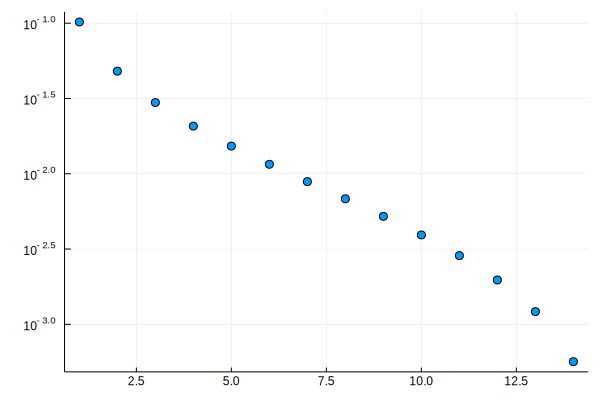

In [5]:
periods=15
errs=[]
for p = 1:periods-1
    perr=[]
    for i = 0:7 
       errx = norm(view(X,Block(9+(p-1)*8 + i,10+(p-1)*8+i))-view(X,Block(n+1-7+i,n+2-7+i)))
       erry = norm(view(Y,Block(9+(p-1)*8 + i,10+(p-1)*8+i))-view(Y,Block(n+1-7+i,n+2-7+i)))
       perr=vcat(perr,errx,erry) 
    end
    errs=vcat(errs,maximum(perr))
end
scatter(1:periods-1,errs;yscale=:log10,legend=false)